# Testing tf-agents library on Wordle Env

This is a recreation of the TF Agents DQN tutorial:
https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

In [1]:
from tqdm import tqdm
from wordle_rl import WordleEnv

# import gym

import tensorflow as tf
import numpy as np

import tf_agents
import reverb

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common


from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

2022-02-16 19:17:00.535878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 19:17:00.535923: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import warnings
warnings.filterwarnings("ignore")

### 1) Hyperparameters of this demo

In [3]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### 2) Convert Gym envs to TFPy envs

Two things are happening here:
1) We're initializing a separate train and eval env
2) We're convering our custom OpenAI Gym env into a TF python env

In [4]:
env = WordleEnv("config.json")
env = tf_agents.environments.gym_wrapper.GymWrapper(env)

gym_train_env = WordleEnv("config.json")
gym_eval_env = WordleEnv("config.json")

py_train_env = tf_agents.environments.gym_wrapper.GymWrapper(gym_train_env)
py_eval_env = tf_agents.environments.gym_wrapper.GymWrapper(gym_eval_env)

train_env = tf_py_environment.TFPyEnvironment(py_train_env)
eval_env = tf_py_environment.TFPyEnvironment(py_eval_env)

### 3) Define a TF agent

TF-Agents library comes with several different algorithms implemented. Here we'll use a DQN. 

Instantiating a DQN with TF-Agents involves: 
1) Defining a Q Network object
2) Feeding that Q Network to a DQN agent object

The "Q Network" is a neural network model that takes env state observations as input and computes Q values as output. Q values here are reward probability estimations for given actions in given env states.

In [5]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
    return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2022-02-16 19:17:10.403612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-16 19:17:10.403679: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-16 19:17:10.403770: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f5bfd35a90d8): /proc/driver/nvidia/version does not exist
2022-02-16 19:17:10.404043: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
agent.policy

In [10]:
agent.collect_policy

### 4) Define a Replay Buffer

This is technically optional. The replay buffer will improve data efficiency, that is we will get more information from each game as the replay buffer lets us replay games to see different outcomes from certain states.

In [11]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(10656)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(60,), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(29, dtype=uint8)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [12]:
# table_name = 'uniform_table'
# replay_buffer_signature = tensor_spec.from_spec(
#       agent.collect_data_spec)
# replay_buffer_signature = tensor_spec.add_outer_dim(
#     replay_buffer_signature)

# table = reverb.Table(
#     table_name,
#     max_size=replay_buffer_max_length,
#     sampler=reverb.selectors.Uniform(),
#     remover=reverb.selectors.Fifo(),
#     rate_limiter=reverb.rate_limiters.MinSize(1),
#     signature=replay_buffer_signature)

# reverb_server = reverb.Server([table])

# replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
#     agent.collect_data_spec,
#     table_name=table_name,
#     sequence_length=2,
#     local_server=reverb_server)

# rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
#   replay_buffer.py_client,
#   table_name,
#   sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmprlz9zac4.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmprlz9zac4
[reverb/cc/platform/default/server.cc:71] Started replay server on port 15931


### 5) Train our agent

In [7]:
time_step = env.reset()

In [8]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

In [9]:
replay_buffer_capacity = 1000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [10]:
replay_observer = [replay_buffer.add_batch]

collect_steps_per_iteration = 10
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [11]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [12]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

In [24]:
agent.train_step_counter

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=10000>

In [13]:
%%time

num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 10000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 4000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}


# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_env.reset()

# Create a driver to collect experience.
collect_steps_per_iteration = 10
collect_op = dynamic_step_driver.DynamicStepDriver(
  train_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2)

iterator = iter(dataset)

for _ in tqdm(range(num_iterations)):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_op.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    # print(time_step)
    experience, unused_info = next(iterator)
    # print(experience)
    train_loss = agent.train(experience).loss
    # print(train_loss)
    step = agent.train_step_counter.numpy()
    # print(step)
    # if step % log_interval == 0:
    #     print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        # print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


WARNING - From /usr/local/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py:383: ReplayBuffer.get_next (from tf_agents.replay_buffers.replay_buffer) is deprecated and will be removed in a future version.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
  0%|          | 0/10000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


WARNING - From /usr/local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: calling foldr_v2 (from tensorflow.python.ops.functional_ops) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
100%|██████████| 10000/10000 [19:51<00:00,  8.39it/s]

CPU times: user 21min 12s, sys: 36.8 s, total: 21min 48s
Wall time: 19min 53s


### 6) Evaluate our agent

We need a way to see how good our policy is performing on our environment

In [14]:
import matplotlib.pyplot as plt

In [15]:
returns

[-9936.6,
 -19942.8,
 -14898.4,
 -9846.2,
 -9907.0,
 -4881.5,
 -4921.5,
 -4894.3,
 -4807.0,
 154.7,
 163.9]

Text(0.5, 0, 'Iterations')

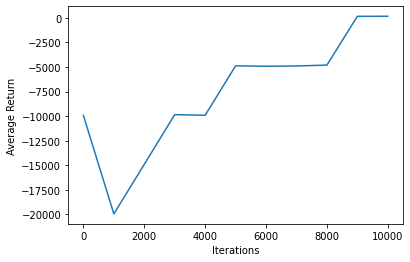

In [16]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
# plt.ylim(top=250)

In [17]:
import utils

In [36]:
utils.play_a_tfagents_game(eval_env,agent)

This game's correct word is: 'hoods'

RL Agent's guesses:
p a t e d      Reward = 1
- - - - - 
c u f f o      Reward = 1
- - - - - 
h e r m s      Reward = 100
- - - - - 
p o t t y      Reward = 50
- - - - - 
c a w e d      Reward = 1
- - - - - 
s u i t s      Reward = 51
- - - - - 

Final Result:
[[[16  1 20  5  4]
  [ 3 21  6  6 15]
  [ 8  5 18 13 19]
  [16 15 20 20 25]
  [ 3  1 23  5  4]
  [19 21  9 20 19]]

 [[27 27 27 27 28]
  [27 27 27 27 28]
  [29 27 27 27 29]
  [27 29 27 27 27]
  [27 27 27 27 28]
  [28 27 27 27 29]]]
